#<font color="blue" size = 20px face = "Arial"><center>**FBI MOST WANTED FUGITIVES<br> Web Scraper**</center></font>



#**Description**

This notebook contains Python code capable of extracting the profile information of fugitives listed as part of the FBI's Most Wanted program. The data is furthermore stored into a DataFrame and can be exported into csv file. The code contained herein relies heavily on the `BeautifulSoup` library (web scraping) and the `pandas` library (data storage).

#**Imports**

The required library imports are specified in the cell below. In addition to `BeautifulSoup` and `pandas` libraries, the `requests` library will be used to perform `HTTPS GET` requests that load webpages from which we desire to extract information. In addition the `OrderedDict` library will be used to ensure the order of DataFrame fields is presented in the order specified (traditional Python dictionaries do not possess this feature).

In [57]:
# BeautifulSoup is used to extract useful information from the requests
from bs4 import BeautifulSoup

# storing retrieved data in a dataframe
import pandas as pd

# requests library is used to send an http request to access information on 
# desired webpages
import requests

# To preserve order of dictionaries used to build dataframes
from collections import OrderedDict

# Time library used to add optional sleep in between HTTP GET requests
import time

# Used for file naming of csv output
from datetime import date

In [58]:
today = date.today().strftime("%m%d%Y")

#**Initializations**

Certain column titles of the resulting dataframe, after webscraping, are set in the following block of code. Specifically, the information of the fields established here contain information from each Most Wanted profile are non-tabulated. The information of these fields are stored in the `dataframe_dict` `OrderedDict`. The information of tabulated fields are stored in the `tabulated_dict` `OrderedDict`. 

In [59]:
# Title of dataframe columns containing pertinent information from Most Wanted
# profiles
name_column = 'Name'
link_column = 'Link'
alias_column = 'Aliases'
reward_column = 'Reward'
remarks_column = 'Remarks'
caution_column = 'Caution'
warning_panel_column = 'Warning Statement'
field_office_column = 'Field Office'
summary_column = 'Summary'
crime_column = 'Crime'

# Store dataframe column names in a list
profile_attributes = [
name_column,
link_column,
alias_column,
reward_column,
remarks_column,
caution_column,
warning_panel_column,
field_office_column,
summary_column,
crime_column
]

# Initialization of the dictionary containing the information on the above
# listed fields
dataframe_dict = OrderedDict()

# Initialization of the dictionary containing the information on tabulated
# fields of Most Wanted profiles
tabulated_dict = OrderedDict()

# Assign an empty list as a value to each key of the dictionary which will
# be used to build the final dataframe
for attribute in profile_attributes:
  dataframe_dict[attribute] = []

# Page number of Most Wanted profiles (each page seems to contain a maximum
# of 40 profiles)
page_number = 1

# A variable which will be used to keep track of the number of profiles
# processed, updated after the required data from every page has been scraped
profiles_processed = 0

page_sleep = False
profile_sleep = False
page_sleep_length = 1
profile_sleep_length = 1

#**Webscraping**

##<font color = "red">**Disclaimer:**</font>##

Prior to performing webscraping on any website, ensure that the website itself does not discourage such activities. The best way to confirm that this is the case is by taking the website's home page (in our case fbi.gov), and adding /robots.txt to the URL. The robots.txt file delineates the freedom with which web crawling can be performed on a website. Let's take a look at the <a href = "fbi.gov/robots.txt">robots.txt</a> file for fbi.gov. It is displayed in the cell immediately below.
<br></br>
The `User-agent` field is set to `*` (asterisk), while the `Disallow` field is left blank. Asterisk for the `User-agent` field implies that the following `Disallow` applies to all web scraping "robots" (programs). In this case, `Disallow` is set as blank, meaning that all webscrapers can access any part of the site, as specified in the comments immediately above. 
<br></br>
Continuing on in the robots.txt file, there are permissions restrictions set for the web crawlers of popular search engines (Googlebot for Google, Bingbot for Bing, Slurp for Yahoo, and DuckDuckBot for DuckDuckGo) which are used for site indexing. These webscrapers are restricted from accessing pages that feature forms for user input. These restrictions do not impede the development of this personal webscraper.

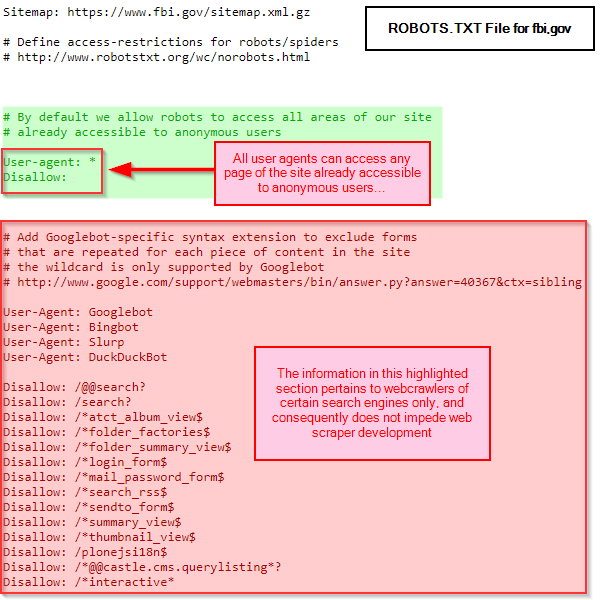

##**Process**

This web scraper will get information on the profiles listed exclusively at <a href = "https://www.fbi.gov/wanted/fugitives">https://www.fbi.gov/wanted/fugitives</a>. Navigate to this link. You should see rows of profiles in a layout as displayed below:

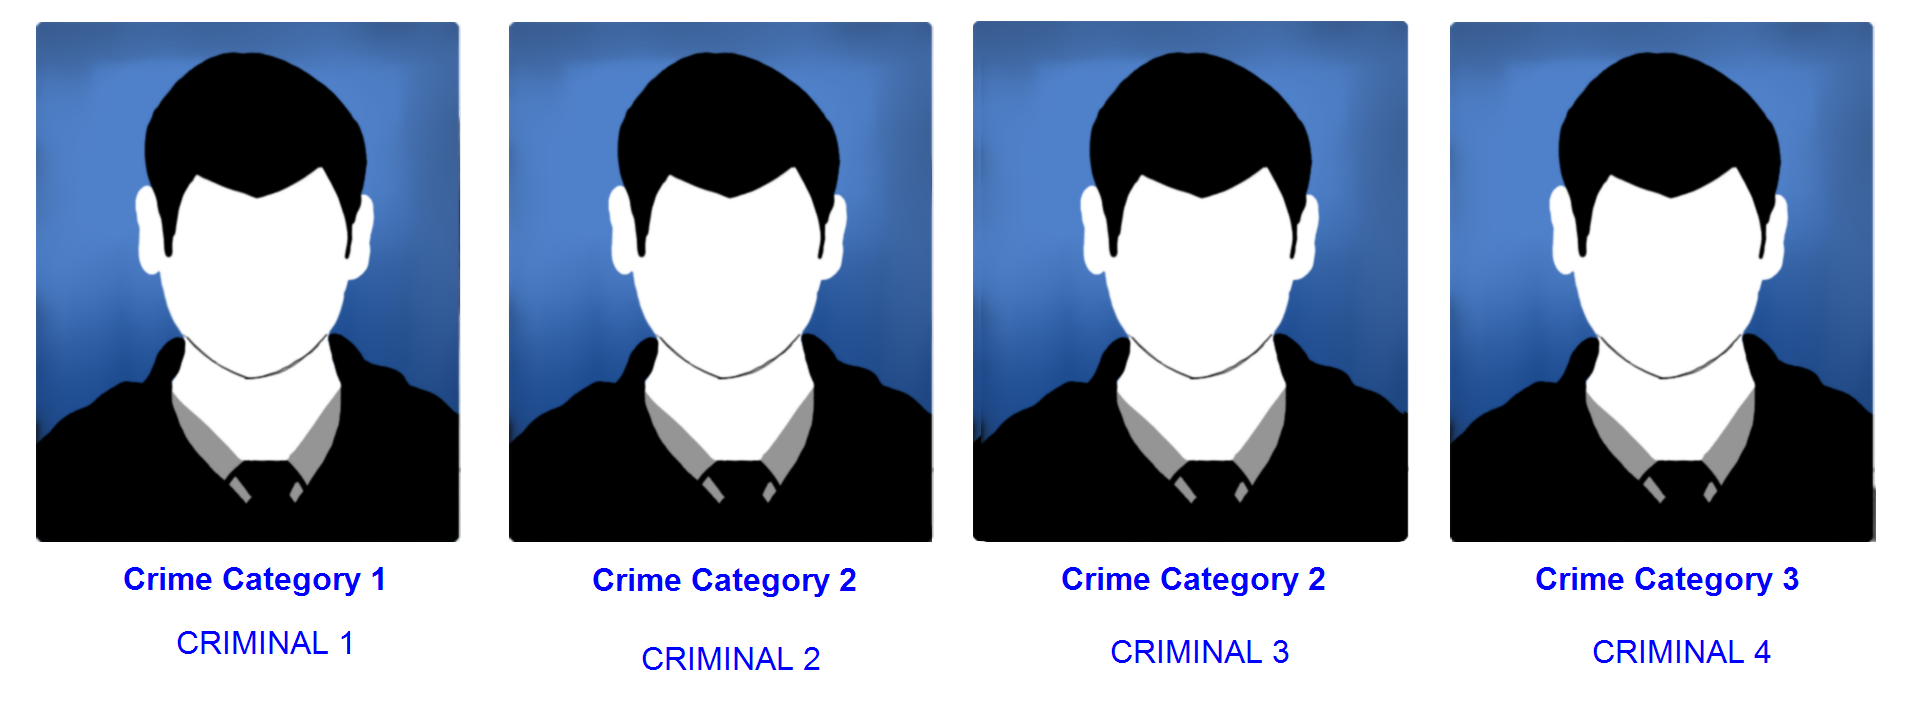

Click into one of the profiles. Information on the profiled fugitive will be displayed in a similar manner to what is seen in the below image. The number sections contain the information we hope to extract for each fugitive. Doing this requires an understanding of the HTML making up these webpages in addition to use of the `BeautifulSoup` library. To see the underlying HTML, (if using Google Chrome) right click on one of the desired fields and select "Inspect" from the pop up menu.

1. Aliases of the profiled fugitive; `<div class="wanted-person-aliases">` tag
2. Reward for providing information leading to fugitive capture; `<div class="wanted-person-reward">` tag
3. Remarks on fugitive; `<div class="wanted-person-remarks">` tag
4. Criminal activity details; `<div class="wanted-person-caution">` tag
5. Warning information; `<div class="wanted-person-warning-panel">` tag
6. Assigned Field Office; `<span class="field-office">` tag
7. Assigned Field Office; `<p class="summary">` tag 
8. Tabulated fugitive details; `<tr>` tags


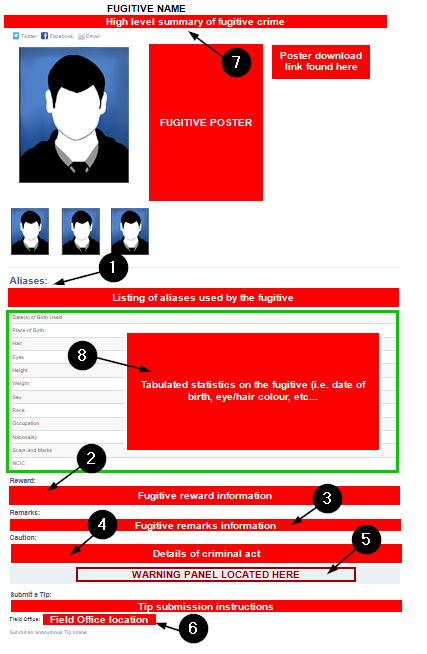

In [60]:
# Loop until a break statement is encountered
while True:

  # Retrieve the URL for a given page of the profile gallery (specified by 'page_number' variable) 
  url = 'https://www.fbi.gov/wanted/fugitives/@@castle.cms.querylisting/f7f80a1681ac41a08266bd0920c9d9d8?page=' + str(page_number)

  # Impose a pause on the script to space out frequency of HTTP GET requests
  # for pages in gallery
  if page_sleep:
    time.sleep(page_sleep_length)

  # Execute the HTTP GET method on the URL, indicating the intention to 
  # retrieve data from the specified URL, store the result into an object 
  # named "response"
  response = requests.get(url)

  # After this is successful, take the text retrieved in performing the HTTP 
  # GET, and apply a parser (in our case the 'lxml' parser) to properly format
  # and structure HTML code pertaining to the URL
  HTML_gallery = BeautifulSoup(response.text, 'lxml')

  # Extract all the HTML 'p' tags with class 'name' - this will return a list
  # of all the fugitive names on the page linked by the URL
  names = HTML_gallery.find_all('p', {'class' : 'name'})

  # Extract all the HTML 'h3' tags with class 'title' - this return a list
  # of the category of crime committed by each fugitive on the page
  categories = HTML_gallery.find_all('h3', {'class' : 'title'})
  
  # Check to see if the retrieved list of names is blank - if so, this indicates
  # that there are no more profiles left to process in the gallery 
  if not names:
    break

  # Loop through the criminal names, marking each with an index by applying 
  # the 'enumerate()' tool, which will be used to access the corresponding 
  # 'categories' list element for each name 
  for idx, name in enumerate(names):

    # Extract the URL associated with the current fugitive's profile by 
    # finding the 'href' attribute of the 'p' tag's child element 
    # (in this case, 'a')
    name_url = name.findChild().get('href')

    # Impose a pause on the script to space out frequency of HTTP GET requests
    # for profiles in gallery
    if profile_sleep:
      time.sleep(profile_sleep_length)

    # Execute the HTTP GET method on the URL associated with a particular
    # fugitive's profile
    name_response = requests.get(name_url)

    # Extract the HTML of the current fugitive's profile page
    HTML_profile = BeautifulSoup(name_response.text, 'lxml')

    # Extract crime summary information for the 
    # current fugitive (if it is present)
    summary = HTML_profile.find('p', {'class' : 'summary'})

    # Extract "Alias" (alternative names/nicknames) information for the 
    # current fugitive (if it is present)
    alias = HTML_profile.find('div', {'class' : 'wanted-person-aliases'})

    # Extract tabulated identifying statistics on the current fugitive 
    # (if it is present)
    tabulated_info = HTML_profile.find_all('tr')

    # Extract "Reward" (monetary reward for capture)
    # information on the current fugitive (if it is present)
    reward = HTML_profile.find('div', {'class' : 'wanted-person-reward'})
    
    # Extract "Remarks" (personal background) on the current fugitive 
    # (if it is present)
    remarks = HTML_profile.find('div', {'class' : 'wanted-person-remarks'})

    # Extract "Caution" information (details on the crime for which fugitives
    # are wanted) on the current fugitive (if it is present)
    caution = HTML_profile.find('div', {'class' : 'wanted-person-caution'})

    # Extract 'Warning' information on the current fugitive (if it is present)
    warning_panel = HTML_profile.find('h3', {'class' : 'wanted-person-warning panel'})

    # Extract the Field Office pertaining to the current fugitive
    field_office = HTML_profile.find('p', {'class' : 'field-office-list'})

    # Store "Alias" information into a variable, if present
    p_complete = None
    if alias != None:
      p_complete = ''
      for i, p in enumerate(alias.find_all('p')):

        if i == 0:
          p_complete = p.text

        else:
          if p.text != '':
            p_complete = p_complete + ' ' + p.text

    alias_info = p_complete

    # Store "Reward" information string into a variable, if present
    p_complete = None
    if reward != None:
      p_complete = ''
      for i, p in enumerate(reward.find_all('p')):

        if i == 0:
          p_complete = p.text
        else:
          if p.text != '':
            p_complete = p_complete + ' ' + p.text

    reward_info = p_complete

    # Store "Remarks" information string into a variable, if present
    p_complete = None
    if remarks != None:
      p_complete = ''
      for i, p in enumerate(remarks.find_all('p')):

        if i == 0:
          p_complete = p.text

        else: 
          if p.text != '':
            p_complete = p_complete + ' ' + p.text

    remarks_info = p_complete

    # Store "Caution" information string into a variable, if present
    p_complete = None
    if caution != None:
      p_complete = ''
      for i, p in enumerate(caution.find_all('p')):

        if i == 0:
          p_complete = p.text
        else:
          if p.text != '':
            p_complete = p_complete + ' ' + p.text

    caution_info = p_complete

    # Store Warning Panel information into a variable, if present
    message = None
    if warning_panel != None:
      message = ''
      message = warning_panel.text.strip('\n')      

    # Store crime summary information into a variable, if present
    if summary != None:
      summary_info = summary.text
    else:
      summary_info = None

    # Store Field Office  information into a variable, if present
    office_list = None
    if field_office != None:
      office_list = ''
      for i, office in enumerate(field_office.find_all('a')):

        if i == 0:
          office_list = office.text  
        else:
          office_list = office_list + ', ' + office.text

    field_office_info = office_list

    # Prepare the dictionaries to be converted into dataframes using the logic
    # below
    table_columns = []
    for item in tabulated_info:
      row = item.find_all('td')

      table_columns.append(row[0].text)
      if row[0].text not in tabulated_dict.keys():
        tabulated_dict[row[0].text] = [None] * (idx + profiles_processed) + [row[1].text]

      else:
        tabulated_dict[row[0].text].append(row[1].text)

    for key in tabulated_dict.keys():
      if key not in table_columns:
        tabulated_dict[key].append(None)

    dataframe_dict[name_column].append(name.text)
    dataframe_dict[link_column].append(name_url)
    dataframe_dict[alias_column].append(alias_info)
    dataframe_dict[reward_column].append(reward_info)
    dataframe_dict[remarks_column].append(remarks_info)
    dataframe_dict[caution_column].append(caution_info)
    dataframe_dict[warning_panel_column].append(message)
    dataframe_dict[field_office_column].append(field_office_info) 
    dataframe_dict[summary_column].append(summary_info)
    dataframe_dict[crime_column].append(categories[idx].text)
    
  # Increment the page number of the profile gallery
  page_number += 1

  profiles_processed += len(names)
  print(profiles_processed, ' profiles processed...')

print('--- PROCESSING COMPLETE ---')

40  profiles processed...
80  profiles processed...
120  profiles processed...
160  profiles processed...
200  profiles processed...
240  profiles processed...
280  profiles processed...
320  profiles processed...
360  profiles processed...
365  profiles processed...
--- PROCESSING COMPLETE ---


In [61]:
# Build the final dataframe containing webscraping results by combining
# the dataframes of tabulated and non-tabulated information into one 
fbi_df = pd.merge(pd.DataFrame(dataframe_dict), pd.DataFrame(tabulated_dict), left_index= True, right_index = True)
fbi_df

,Name,Link,Aliases,Reward,Remarks,Caution,Warning Statement,Field Office,Summary,Crime,Date(s) of Birth Used,Place of Birth,Hair,Eyes,Height,Weight,Sex,Race,Occupation,Nationality,Scars and Marks,NCIC,Languages,Build,Complexion,Citizenship,Age
0,JUAN JOSE ESPARRAGOZA-MORENO,https://www.fbi.gov/wanted/cei/juan-jose-espar...,"Juan Jose Esparragoza-Martinez, Jose Luis Espa...","The U.S. Department of State, Bureau for Inter...",Esparragoza-Moreno is believed to have had pla...,The drug trafficking organization led by Juan ...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,El Paso,Conspiracy to Import a Controlled Substance; C...,Criminal Enterprise Investigations,"February 3, 1949","Chuicopa, Sinaloa, Mexico",Black,Brown,"5'8""",200 pounds,Male,White (Hispanic),Unknown,Mexican,None known,W456628782,None,None,None,None,None
1,JUAN CARLOS MARTINEZ,https://www.fbi.gov/wanted/murders/juan-carlos...,Juan D. Martinez,The FBI is offering a reward for information ...,Martinez speaks fluent English and Spanish. He...,Juan Carlos Martinez is wanted for his alleged...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Birmingham,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"December 2, 1978, December 14, 1981",Mexico,Black,Brown,"5'6""",135 pounds,Male,White (Hispanic),"Welder, Machinist, Metal Fabricator, Interpret...",Mexican,None known,W165633135,None,None,None,None,None
2,CHRISTOPHER ROBERT METSOS,https://www.fbi.gov/wanted/counterintelligence...,"Christopher R. Metsos, Pavel Kapustin, Gerard ...","The FBI is offering a reward of up to $50,000 ...",Metsos may have fled to Russia. He has travell...,Christopher Robert Metsos is wanted for failin...,SHOULD BE CONSIDERED AN ESCAPE RISK,New York,Conspiracy to Act as an Unregistered Agent of ...,Counterintelligence,"June 16, 1956, April 7, 1954, November 17, 195...",Canada,Light Brown (Balding),Brown,"5'11"" to 6'0""",180 to 195 pounds,Male,White,None,Canadian,Metsos has a scar on his chest and burn/pock m...,W560713749,None,None,None,None,None
3,YURY YEVGENYEVICH SAVIN,https://www.fbi.gov/wanted/counterintelligence...,Yuri Savin,None,Savin travels and has traveled to Thailand and...,"Yury Savin and his co-conspirator, Sergey Klin...",None,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"January 12, 1975","Moscow, Russia",Brown,Blue,"5'10""",180 pounds,Male,White,"Savin worked for Atrilor LLC in Moscow, which ...",Russian,Savin has a cleft chin.,W026005886,None,None,None,None,None
4,SERGEY YEVGENYEVICH KLINOV,https://www.fbi.gov/wanted/counterintelligence...,None,None,"Regarding his appearance, Klinov has long ears...","Sergey Klinov and his co-conspirator, Yury Sav...",None,Houston,International Emergency Economic Powers Act (I...,Counterintelligence,"February 18, 1968","Tymovskoye, Russia",Balding pattern with a tufted spot on top of h...,Brown,None,None,Male,White,Klinov is the owner of APEX and Mig Electronic...,Russian,None,W196000828,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,JOSE ROSENDO CARRILLO-PADILLA,https://www.fbi.gov/wanted/murders/jose-rosend...,"Jose Carrillo-Padilla, Rosendo Carrillo, Jose ...",None,Carrillo-Padilla is known to abuse alcohol. He...,Jose Rosendo Carrillo-Padilla is wanted for hi...,SHOULD BE CONSIDERED ARMED AND DANGEROUS,Portland,Unlawful Flight to Avoid Prosecution - Murder,Violent Crimes - Murders,"August 15, 1978","Zacatecas, Mexico",Black,Brown,"5'4""",150 pounds,Male,White (Hispanic),Unknown,Mexican,Carrillo-Padilla has tattoos of teardrops on h...,W612612112,None,None,None,None,None
361,RICHARD AYVAZYAN,https://www.fbi.gov/wanted/wcc/richard-ayvazyan,"Iuliia Zhadko, Richard Avazian, Mark Zindroski...",None,"Ayvazyan has previously resided in Topeka, Kan...",Richard Ayvazyan and his co-conspirator (and s...,None,Los Angeles,Violation of Pretrial Release,White Collar Crimes,"August 20, 1978, August 2, 1978",Armenia,Blac

In [62]:
# Export the dataframe to a csv
today = date.today().strftime("%m%d%Y")
fbi_df.to_csv('FBI_' + today + '.csv', encoding = 'utf-8-sig')